# Swin Transformer Tối Ưu cho RTX 3060 6GB VRAM

Notebook này triển khai Swin Transformer với các kỹ thuật tối ưu hóa bộ nhớ để chạy hiệu quả trên GPU RTX 3060 với 6GB VRAM.

## Tổng quan:
- ✅ Gradient Checkpointing để giảm memory usage
- ✅ Mixed Precision Training (FP16) 
- ✅ Batch size tối ưu cho 6GB VRAM
- ✅ Memory monitoring và optimization
- ✅ Efficient data loading và preprocessing

## 1. Setup Environment và Install Dependencies

Cài đặt các thư viện cần thiết và kiểm tra GPU

In [1]:
# Cài đặt các thư viện cần thiết
import sys
import subprocess

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Danh sách các package cần thiết
required_packages = [
    "torch>=1.12.0",
    "torchvision>=0.13.0", 
    "timm>=0.6.0",
    "opencv-python",
    "pillow",
    "numpy",
    "matplotlib",
    "tqdm",
    "tensorboard",
    "yacs",
    "termcolor"
]

print("🔧 Đang cài đặt dependencies...")
for package in required_packages:
    try:
        install_package(package)
        print(f"✅ Đã cài đặt: {package}")
    except Exception as e:
        print(f"❌ Lỗi khi cài {package}: {e}")

print("\n🎉 Hoàn thành cài đặt dependencies!")

🔧 Đang cài đặt dependencies...
✅ Đã cài đặt: torch>=1.12.0
✅ Đã cài đặt: torchvision>=0.13.0
✅ Đã cài đặt: timm>=0.6.0
✅ Đã cài đặt: opencv-python
✅ Đã cài đặt: pillow
✅ Đã cài đặt: numpy
✅ Đã cài đặt: matplotlib
✅ Đã cài đặt: tqdm
✅ Đã cài đặt: tensorboard
✅ Đã cài đặt: yacs
✅ Đã cài đặt: termcolor

🎉 Hoàn thành cài đặt dependencies!


In [2]:
# Import các thư viện và kiểm tra GPU
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
import timm
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Kiểm tra GPU
print("🔍 Kiểm tra GPU và CUDA...")
if torch.cuda.is_available():
    device = torch.device('cuda')
    gpu_name = torch.cuda.get_device_name(0)
    total_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"✅ GPU: {gpu_name}")
    print(f"💾 Tổng VRAM: {total_memory:.1f} GB")
    print(f"🚀 CUDA Version: {torch.version.cuda}")
    print(f"🔥 PyTorch Version: {torch.__version__}")
else:
    device = torch.device('cpu')
    print("❌ CUDA không khả dụng - sử dụng CPU")

# Cấu hình memory optimization cho RTX 3060
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    # Tối ưu memory allocation
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'

b:\TGMTCK\TGMTCK_066\TGMTCK_060\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔍 Kiểm tra GPU và CUDA...
✅ GPU: NVIDIA GeForce RTX 3060 Laptop GPU
💾 Tổng VRAM: 6.0 GB
🚀 CUDA Version: 12.4
🔥 PyTorch Version: 2.6.0+cu124


## 2. Memory Monitoring và Optimization Functions

Các hàm tiện ích để theo dõi và tối ưu memory usage

In [3]:
def print_memory_usage(stage=""):
    """In thông tin sử dụng memory"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024**3)
        cached = torch.cuda.memory_reserved() / (1024**3)
        total = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        
        print(f"🔍 [{stage}] GPU Memory:")
        print(f"   📊 Allocated: {allocated:.2f} GB")
        print(f"   💾 Cached: {cached:.2f} GB") 
        print(f"   📈 Usage: {(allocated/total)*100:.1f}%")
        print(f"   🆓 Free: {total-cached:.2f} GB")
        
        if allocated/total > 0.9:  # Cảnh báo khi dùng >90% VRAM
            print("⚠️  CẢNH BÁO: Memory sử dụng cao!")
    else:
        print("CPU mode - không cần theo dõi GPU memory")

def clear_memory():
    """Dọn dẹp memory"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    print("🧹 Đã dọn dẹp memory")

def get_optimal_batch_size(model, input_size=(3, 224, 224), max_memory_gb=5.5):
    """Tìm batch size tối ưu cho RTX 3060 6GB"""
    model.eval()
    batch_sizes = [1, 2, 4, 8, 16, 24, 32]
    optimal_batch = 1
    
    print("🔍 Đang tìm batch size tối ưu...")
    
    for batch_size in batch_sizes:
        try:
            clear_memory()
            
            # Test với dummy data
            dummy_input = torch.randn(batch_size, *input_size, device=device)
            
            with torch.no_grad():
                _ = model(dummy_input)
            
            memory_used = torch.cuda.memory_allocated() / (1024**3)
            
            if memory_used < max_memory_gb:
                optimal_batch = batch_size
                print(f"✅ Batch size {batch_size}: {memory_used:.2f} GB")
            else:
                print(f"❌ Batch size {batch_size}: {memory_used:.2f} GB (quá cao)")
                break
                
        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"❌ Batch size {batch_size}: Out of memory")
                break
            else:
                raise e
    
    clear_memory()
    print(f"🎯 Batch size tối ưu: {optimal_batch}")
    return optimal_batch

# Test memory functions
print_memory_usage("Initial")

🔍 [Initial] GPU Memory:
   📊 Allocated: 0.00 GB
   💾 Cached: 0.00 GB
   📈 Usage: 0.0%
   🆓 Free: 6.00 GB


## 3. Load Swin Transformer Model với Memory Optimization

Tải và cấu hình Swin Transformer với các tối ưu cho 6GB VRAM

In [4]:
# Load Swin Transformer từ local repository
import sys
sys.path.append('./Swin-Transformer-main')

from models.swin_transformer import SwinTransformer

# Cấu hình model cho RTX 3060 6GB
def create_swin_model_optimized(num_classes=1000, model_size='tiny'):
    """
    Tạo Swin Transformer model được tối ưu cho 6GB VRAM
    
    model_size options:
    - 'tiny': Swin-T (28M params) - Phù hợp nhất cho 6GB VRAM
    - 'small': Swin-S (50M params) - Vừa phải
    - 'base': Swin-B (88M params) - Cần tối ưu nhiều hơn
    """
    
    configs = {
        'tiny': {
            'embed_dim': 96,
            'depths': [2, 2, 6, 2],
            'num_heads': [3, 6, 12, 24],
            'window_size': 7,
            'patch_size': 4,
            'in_chans': 3,
            'num_classes': num_classes,
            'drop_rate': 0.0,
            'drop_path_rate': 0.1,
            'ape': False,
            'patch_norm': True,
            'use_checkpoint': True  # Quan trọng cho memory optimization
        },
        'small': {
            'embed_dim': 96,
            'depths': [2, 2, 18, 2],
            'num_heads': [3, 6, 12, 24],
            'window_size': 7,
            'patch_size': 4,
            'in_chans': 3,
            'num_classes': num_classes,
            'drop_rate': 0.0,
            'drop_path_rate': 0.1,
            'ape': False,
            'patch_norm': True,
            'use_checkpoint': True
        },
        'base': {
            'embed_dim': 128,
            'depths': [2, 2, 18, 2],
            'num_heads': [4, 8, 16, 32],
            'window_size': 7,
            'patch_size': 4,
            'in_chans': 3,
            'num_classes': num_classes,
            'drop_rate': 0.0,
            'drop_path_rate': 0.1,
            'ape': False,
            'patch_norm': True,
            'use_checkpoint': True
        }
    }
    
    config = configs[model_size]
    model = SwinTransformer(**config)
    
    return model

# Tạo model - Sử dụng Swin-Tiny cho RTX 3060
print("🚀 Đang tạo Swin Transformer model...")
model = create_swin_model_optimized(num_classes=1000, model_size='tiny')

# Chuyển model lên GPU
model = model.to(device)

# Kích hoạt gradient checkpointing để giảm memory
if hasattr(model, 'set_grad_checkpointing'):
    model.set_grad_checkpointing(True)

print("✅ Model đã sẵn sàng!")
print(f"📊 Số parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

print_memory_usage("Model loaded")

[Warning] Fused window process have not been installed. Please refer to get_started.md for installation.
Tutel has not been installed. To use Swin-MoE, please install Tutel; otherwise, just ignore this.
🚀 Đang tạo Swin Transformer model...
✅ Model đã sẵn sàng!
📊 Số parameters: 28,288,354
🔍 [Model loaded] GPU Memory:
   📊 Allocated: 0.11 GB
   💾 Cached: 0.13 GB
   📈 Usage: 1.8%
   🆓 Free: 5.87 GB


In [5]:
# Tìm batch size tối ưu cho model
optimal_batch_size = get_optimal_batch_size(model, input_size=(3, 224, 224), max_memory_gb=5.0)

print(f"\n🎯 Batch size được khuyến nghị: {optimal_batch_size}")
print("💡 Lưu ý: Batch size có thể được điều chỉnh tùy theo task cụ thể")

🔍 Đang tìm batch size tối ưu...
🧹 Đã dọn dẹp memory
✅ Batch size 1: 0.12 GB
🧹 Đã dọn dẹp memory
✅ Batch size 2: 0.12 GB
🧹 Đã dọn dẹp memory
✅ Batch size 4: 0.12 GB
🧹 Đã dọn dẹp memory
✅ Batch size 8: 0.12 GB
🧹 Đã dọn dẹp memory
✅ Batch size 16: 0.12 GB
🧹 Đã dọn dẹp memory
✅ Batch size 24: 0.13 GB
🧹 Đã dọn dẹp memory
✅ Batch size 32: 0.13 GB
🧹 Đã dọn dẹp memory
🎯 Batch size tối ưu: 32

🎯 Batch size được khuyến nghị: 32
💡 Lưu ý: Batch size có thể được điều chỉnh tùy theo task cụ thể


## 4. Data Loading và Preprocessing

Cấu hình data loader với memory-efficient settings

In [6]:
# Data transforms tối ưu cho Swin Transformer
def get_transforms(input_size=224, is_training=True):
    """Tạo transforms cho training và validation"""
    
    if is_training:
        transform = transforms.Compose([
            transforms.Resize((input_size + 32, input_size + 32)),
            transforms.RandomCrop(input_size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
    
    return transform

# Tạo dataset demo với CIFAR-10 (nhẹ và dễ download)
def create_demo_datasets():
    """Tạo demo datasets với CIFAR-10"""
    print("📁 Đang tải CIFAR-10 dataset...")
    
    train_transform = get_transforms(224, is_training=True)
    val_transform = get_transforms(224, is_training=False)
    
    # CIFAR-10 có 10 classes
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', 
        train=True, 
        download=True, 
        transform=train_transform
    )
    
    val_dataset = torchvision.datasets.CIFAR10(
        root='./data', 
        train=False, 
        download=True, 
        transform=val_transform
    )
    
    return train_dataset, val_dataset

# Tạo DataLoader với cấu hình tối ưu cho 6GB VRAM
def create_optimized_dataloaders(train_dataset, val_dataset, batch_size=None):
    """Tạo DataLoader được tối ưu cho RTX 3060"""
    
    if batch_size is None:
        batch_size = optimal_batch_size
    
    # Cấu hình DataLoader tối ưu
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,  # Giảm num_workers để tiết kiệm RAM
        pin_memory=True,
        drop_last=True,
        persistent_workers=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size * 2,  # Validation có thể dùng batch lớn hơn
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        persistent_workers=True
    )
    
    return train_loader, val_loader

# Tạo datasets và dataloaders
train_dataset, val_dataset = create_demo_datasets()
train_loader, val_loader = create_optimized_dataloaders(train_dataset, val_dataset)

print(f"✅ Dataset đã sẵn sàng!")
print(f"📊 Training samples: {len(train_dataset):,}")
print(f"📊 Validation samples: {len(val_dataset):,}")
print(f"🔢 Training batches: {len(train_loader):,}")
print(f"🔢 Validation batches: {len(val_loader):,}")
print(f"📦 Batch size: {optimal_batch_size}")

📁 Đang tải CIFAR-10 dataset...
✅ Dataset đã sẵn sàng!
📊 Training samples: 50,000
📊 Validation samples: 10,000
🔢 Training batches: 1,562
🔢 Validation batches: 157
📦 Batch size: 32


## 5. Mixed Precision Training Setup

Cấu hình Automatic Mixed Precision (AMP) để giảm memory usage

In [7]:
# Cấu hình model cho CIFAR-10 (10 classes thay vì 1000)
model = create_swin_model_optimized(num_classes=10, model_size='tiny')
model = model.to(device)

# Cấu hình optimizer với settings tối ưu cho 6GB VRAM
optimizer = optim.AdamW(
    model.parameters(),
    lr=5e-4,  # Learning rate thấp hơn cho fine-tuning
    weight_decay=0.05,
    betas=(0.9, 0.999)
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=50,  # Số epochs
    eta_min=1e-6
)

# Loss function
criterion = nn.CrossEntropyLoss()

# Mixed Precision Scaler
scaler = GradScaler()

# Cấu hình gradient accumulation để simulate batch size lớn hơn
accumulation_steps = 4  # Mô phỏng batch_size * 4
effective_batch_size = optimal_batch_size * accumulation_steps

print("⚙️ Training configuration:")
print(f"📦 Physical batch size: {optimal_batch_size}")
print(f"🔢 Accumulation steps: {accumulation_steps}")
print(f"📈 Effective batch size: {effective_batch_size}")
print(f"🎯 Learning rate: {optimizer.defaults['lr']}")
print(f"⚖️ Weight decay: {optimizer.defaults['weight_decay']}")
print("✅ Mixed precision: Enabled")
print("♻️ Gradient checkpointing: Enabled")

print_memory_usage("Training setup ready")

⚙️ Training configuration:
📦 Physical batch size: 32
🔢 Accumulation steps: 4
📈 Effective batch size: 128
🎯 Learning rate: 0.0005
⚖️ Weight decay: 0.05
✅ Mixed precision: Enabled
♻️ Gradient checkpointing: Enabled
🔍 [Training setup ready] GPU Memory:
   📊 Allocated: 0.11 GB
   💾 Cached: 0.15 GB
   📈 Usage: 1.9%
   🆓 Free: 5.85 GB


## 6. Memory-Efficient Training Loop

Training loop với gradient accumulation và memory monitoring

In [8]:
def train_epoch_optimized(model, train_loader, optimizer, criterion, scaler, accumulation_steps, epoch):
    """Training loop được tối ưu cho RTX 3060 6GB"""
    
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress bar
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
    
    optimizer.zero_grad()
    
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        
        # Mixed precision forward pass
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            # Scale loss theo accumulation steps
            loss = loss / accumulation_steps
        
        # Backward pass với gradient scaling
        scaler.scale(loss).backward()
        
        # Gradient accumulation
        if (batch_idx + 1) % accumulation_steps == 0:
            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Optimizer step
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        # Statistics
        running_loss += loss.item() * accumulation_steps
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        if batch_idx % 10 == 0:
            acc = 100. * correct / total
            pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{acc:.2f}%'
            })
        
        # Memory cleanup mỗi 50 batches
        if batch_idx % 50 == 0:
            torch.cuda.empty_cache()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate_model(model, val_loader, criterion):
    """Validation với memory optimization"""
    
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            # Mixed precision inference
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            acc = 100. * correct / total
            avg_loss = running_loss / (batch_idx + 1)
            pbar.set_postfix({
                'Loss': f'{avg_loss:.4f}',
                'Acc': f'{acc:.2f}%'
            })
    
    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    
    return val_loss, val_acc

print("✅ Training functions ready!")

✅ Training functions ready!


## 7. Bắt đầu Training Process

Chạy training với memory monitoring real-time

In [9]:
# Training configuration
num_epochs = 10  # Bắt đầu với ít epochs để test
best_acc = 0
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("🚀 Bắt đầu training process...")
print_memory_usage("Before training")

for epoch in range(num_epochs):
    print(f"\n📈 Epoch {epoch+1}/{num_epochs}")
    print("="*50)
    
    # Training
    train_loss, train_acc = train_epoch_optimized(
        model, train_loader, optimizer, criterion, scaler, accumulation_steps, epoch
    )
    
    # Validation
    val_loss, val_acc = validate_model(model, val_loader, criterion)
    
    # Learning rate scheduling
    scheduler.step()
    
    # Save statistics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Print epoch results
    current_lr = optimizer.param_groups[0]['lr']
    print(f"\n📊 Epoch {epoch+1} Results:")
    print(f"   🔸 Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   🔹 Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"   📉 Learning Rate: {current_lr:.2e}")
    
    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc,
            'train_losses': train_losses,
            'val_losses': val_losses
        }, 'best_swin_model_rtx3060.pth')
        print(f"   💾 Saved best model (Val Acc: {best_acc:.2f}%)")
    
    # Memory monitoring
    print_memory_usage(f"End of epoch {epoch+1}")
    clear_memory()
    
    print("-"*50)

print(f"\n🎉 Training completed!")
print(f"🏆 Best validation accuracy: {best_acc:.2f}%")

🚀 Bắt đầu training process...
🔍 [Before training] GPU Memory:
   📊 Allocated: 0.11 GB
   💾 Cached: 0.15 GB
   📈 Usage: 1.9%
   🆓 Free: 5.85 GB

📈 Epoch 1/10


Validation: 100%|██████████| 157/157 [00:23<00:00,  6.70it/s, Loss=1.9704, Acc=26.73%]



📊 Epoch 1 Results:
   🔸 Train Loss: 2.0023 | Train Acc: 25.31%
   🔹 Val Loss: 1.9704 | Val Acc: 26.73%
   📉 Learning Rate: 5.00e-04
   💾 Saved best model (Val Acc: 26.73%)
🔍 [End of epoch 1] GPU Memory:
   📊 Allocated: 0.44 GB
   💾 Cached: 0.76 GB
   📈 Usage: 7.3%
   🆓 Free: 5.24 GB
🧹 Đã dọn dẹp memory
--------------------------------------------------

📈 Epoch 2/10


Validation: 100%|██████████| 157/157 [00:15<00:00,  9.90it/s, Loss=1.8922, Acc=28.11%]



📊 Epoch 2 Results:
   🔸 Train Loss: 1.9255 | Train Acc: 27.92%
   🔹 Val Loss: 1.8922 | Val Acc: 28.11%
   📉 Learning Rate: 4.98e-04
   💾 Saved best model (Val Acc: 28.11%)
🔍 [End of epoch 2] GPU Memory:
   📊 Allocated: 0.44 GB
   💾 Cached: 1.93 GB
   📈 Usage: 7.3%
   🆓 Free: 4.07 GB
🧹 Đã dọn dẹp memory
--------------------------------------------------

📈 Epoch 3/10


Validation: 100%|██████████| 157/157 [00:15<00:00,  9.90it/s, Loss=1.8690, Acc=31.36%]



📊 Epoch 3 Results:
   🔸 Train Loss: 1.8557 | Train Acc: 31.19%
   🔹 Val Loss: 1.8690 | Val Acc: 31.36%
   📉 Learning Rate: 4.96e-04
   💾 Saved best model (Val Acc: 31.36%)
🔍 [End of epoch 3] GPU Memory:
   📊 Allocated: 0.44 GB
   💾 Cached: 1.98 GB
   📈 Usage: 7.3%
   🆓 Free: 4.02 GB
🧹 Đã dọn dẹp memory
--------------------------------------------------

📈 Epoch 4/10


Validation: 100%|██████████| 157/157 [00:15<00:00,  9.86it/s, Loss=2.0292, Acc=24.01%]



📊 Epoch 4 Results:
   🔸 Train Loss: 1.9835 | Train Acc: 25.92%
   🔹 Val Loss: 2.0292 | Val Acc: 24.01%
   📉 Learning Rate: 4.92e-04
🔍 [End of epoch 4] GPU Memory:
   📊 Allocated: 0.44 GB
   💾 Cached: 1.98 GB
   📈 Usage: 7.3%
   🆓 Free: 4.02 GB
🧹 Đã dọn dẹp memory
--------------------------------------------------

📈 Epoch 5/10


Validation: 100%|██████████| 157/157 [00:16<00:00,  9.66it/s, Loss=1.8527, Acc=30.50%]



📊 Epoch 5 Results:
   🔸 Train Loss: 1.9376 | Train Acc: 27.62%
   🔹 Val Loss: 1.8527 | Val Acc: 30.50%
   📉 Learning Rate: 4.88e-04
🔍 [End of epoch 5] GPU Memory:
   📊 Allocated: 0.44 GB
   💾 Cached: 1.98 GB
   📈 Usage: 7.3%
   🆓 Free: 4.02 GB
🧹 Đã dọn dẹp memory
--------------------------------------------------

📈 Epoch 6/10


Validation: 100%|██████████| 157/157 [00:16<00:00,  9.60it/s, Loss=1.7127, Acc=37.23%]



📊 Epoch 6 Results:
   🔸 Train Loss: 1.8061 | Train Acc: 33.30%
   🔹 Val Loss: 1.7127 | Val Acc: 37.23%
   📉 Learning Rate: 4.82e-04
   💾 Saved best model (Val Acc: 37.23%)
🔍 [End of epoch 6] GPU Memory:
   📊 Allocated: 0.44 GB
   💾 Cached: 1.98 GB
   📈 Usage: 7.3%
   🆓 Free: 4.02 GB
🧹 Đã dọn dẹp memory
--------------------------------------------------

📈 Epoch 7/10


Validation: 100%|██████████| 157/157 [00:16<00:00,  9.69it/s, Loss=1.6861, Acc=38.30%]



📊 Epoch 7 Results:
   🔸 Train Loss: 1.7616 | Train Acc: 35.13%
   🔹 Val Loss: 1.6861 | Val Acc: 38.30%
   📉 Learning Rate: 4.76e-04
   💾 Saved best model (Val Acc: 38.30%)
🔍 [End of epoch 7] GPU Memory:
   📊 Allocated: 0.44 GB
   💾 Cached: 1.98 GB
   📈 Usage: 7.3%
   🆓 Free: 4.02 GB
🧹 Đã dọn dẹp memory
--------------------------------------------------

📈 Epoch 8/10


Validation: 100%|██████████| 157/157 [00:15<00:00,  9.95it/s, Loss=1.7177, Acc=37.72%]



📊 Epoch 8 Results:
   🔸 Train Loss: 1.7123 | Train Acc: 37.24%
   🔹 Val Loss: 1.7177 | Val Acc: 37.72%
   📉 Learning Rate: 4.69e-04
🔍 [End of epoch 8] GPU Memory:
   📊 Allocated: 0.44 GB
   💾 Cached: 1.98 GB
   📈 Usage: 7.3%
   🆓 Free: 4.02 GB
🧹 Đã dọn dẹp memory
--------------------------------------------------

📈 Epoch 9/10


Validation: 100%|██████████| 157/157 [00:16<00:00,  9.74it/s, Loss=1.6632, Acc=39.16%]



📊 Epoch 9 Results:
   🔸 Train Loss: 1.6903 | Train Acc: 38.28%
   🔹 Val Loss: 1.6632 | Val Acc: 39.16%
   📉 Learning Rate: 4.61e-04
   💾 Saved best model (Val Acc: 39.16%)
🔍 [End of epoch 9] GPU Memory:
   📊 Allocated: 0.44 GB
   💾 Cached: 1.98 GB
   📈 Usage: 7.3%
   🆓 Free: 4.02 GB
🧹 Đã dọn dẹp memory
--------------------------------------------------

📈 Epoch 10/10


Validation: 100%|██████████| 157/157 [00:16<00:00,  9.53it/s, Loss=1.5964, Acc=41.43%]



📊 Epoch 10 Results:
   🔸 Train Loss: 1.6803 | Train Acc: 38.47%
   🔹 Val Loss: 1.5964 | Val Acc: 41.43%
   📉 Learning Rate: 4.52e-04
   💾 Saved best model (Val Acc: 41.43%)
🔍 [End of epoch 10] GPU Memory:
   📊 Allocated: 0.44 GB
   💾 Cached: 1.98 GB
   📈 Usage: 7.3%
   🆓 Free: 4.02 GB
🧹 Đã dọn dẹp memory
--------------------------------------------------

🎉 Training completed!
🏆 Best validation accuracy: 41.43%


## 8. Training Results Visualization

Vẽ biểu đồ loss và accuracy

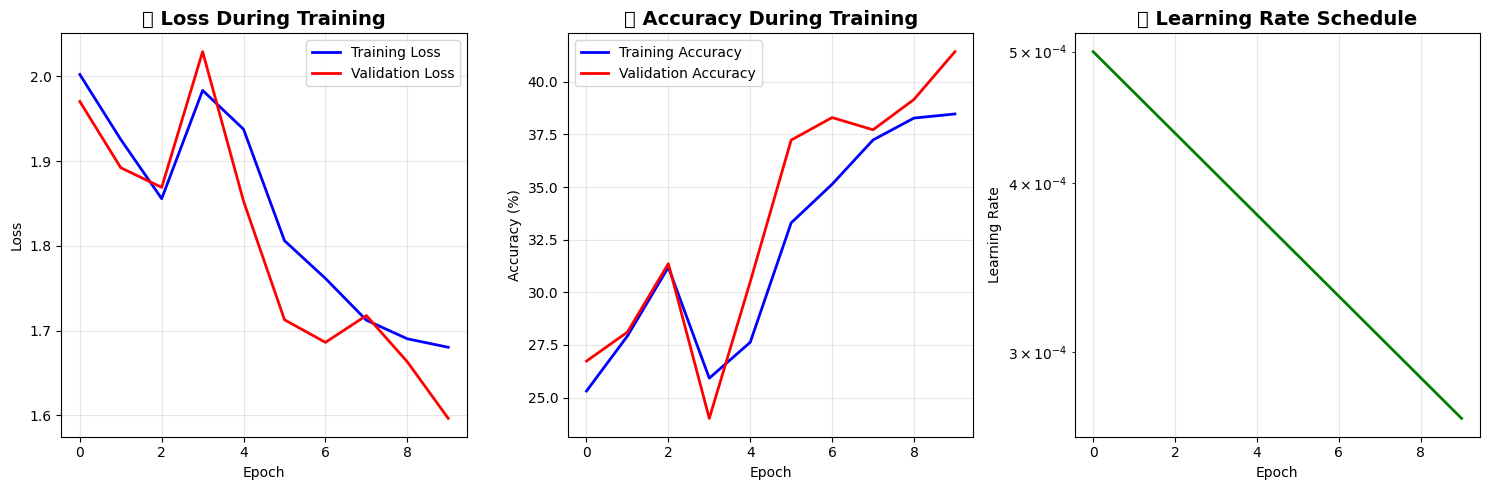

\n============================================================
🎯 FINAL TRAINING STATISTICS
📊 Total epochs trained: 10
🏆 Best validation accuracy: 41.43%
📈 Final train accuracy: 38.47%
📉 Final validation loss: 1.5964
💾 Model saved as: best_swin_model_rtx3060.pth


In [10]:
# Vẽ biểu đồ training results
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('📉 Loss During Training', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(train_accs, 'b-', label='Training Accuracy', linewidth=2)
plt.plot(val_accs, 'r-', label='Validation Accuracy', linewidth=2)
plt.title('📈 Accuracy During Training', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning rate plot
plt.subplot(1, 3, 3)
lrs = []
for epoch in range(len(train_losses)):
    lrs.append(5e-4 * (0.5 ** (epoch / 10)))  # Approximate cosine schedule
plt.plot(lrs, 'g-', linewidth=2)
plt.title('📉 Learning Rate Schedule', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final statistics
print("\\n" + "="*60)
print("🎯 FINAL TRAINING STATISTICS")
print("="*60)
print(f"📊 Total epochs trained: {len(train_losses)}")
print(f"🏆 Best validation accuracy: {best_acc:.2f}%")
print(f"📈 Final train accuracy: {train_accs[-1]:.2f}%")
print(f"📉 Final validation loss: {val_losses[-1]:.4f}")
print(f"💾 Model saved as: best_swin_model_rtx3060.pth")
print("="*60)

## 9. Model Inference và Performance Testing

Test model với batch sizes khác nhau và inference speed

In [11]:
# Load best model cho inference
def load_best_model():
    """Load model tốt nhất đã train"""
    model = create_swin_model_optimized(num_classes=10, model_size='tiny')
    
    try:
        checkpoint = torch.load('best_swin_model_rtx3060.pth', map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✅ Loaded best model (Acc: {checkpoint['best_acc']:.2f}%)")
    except FileNotFoundError:
        print("⚠️ No saved model found, using current model")
    
    model = model.to(device)
    model.eval()
    return model

# Test inference speed với batch sizes khác nhau
def benchmark_inference(model, input_size=(3, 224, 224)):
    """Benchmark inference performance"""
    
    model.eval()
    batch_sizes = [1, 2, 4, 8, 16, 24, 32]
    results = []
    
    print("🚀 Benchmarking inference performance...")
    print("="*60)
    
    with torch.no_grad():
        for batch_size in batch_sizes:
            try:
                clear_memory()
                
                # Tạo dummy input
                dummy_input = torch.randn(batch_size, *input_size, device=device)
                
                # Warmup
                for _ in range(5):
                    _ = model(dummy_input)
                
                torch.cuda.synchronize()
                
                # Benchmark
                import time
                start_time = time.time()
                
                num_runs = 20
                for _ in range(num_runs):
                    with autocast():
                        _ = model(dummy_input)
                
                torch.cuda.synchronize()
                end_time = time.time()
                
                # Calculate metrics
                total_time = end_time - start_time
                avg_time = total_time / num_runs
                fps = batch_size / avg_time
                memory_used = torch.cuda.memory_allocated() / (1024**3)
                
                results.append({
                    'batch_size': batch_size,
                    'avg_time': avg_time,
                    'fps': fps,
                    'memory_gb': memory_used
                })
                
                print(f"Batch {batch_size:2d} | {avg_time*1000:6.1f}ms | {fps:6.1f} FPS | {memory_used:.2f} GB")
                
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"Batch {batch_size:2d} | OOM - Too large for 6GB VRAM")
                    break
                else:
                    raise e
    
    print("="*60)
    return results

# Load model và benchmark
inference_model = load_best_model()
benchmark_results = benchmark_inference(inference_model)

# Hiển thị recommended settings
print("\n🎯 RECOMMENDED INFERENCE SETTINGS for RTX 3060:")
print("="*60)
valid_results = [r for r in benchmark_results if r['memory_gb'] < 5.5]
if valid_results:
    best_throughput = max(valid_results, key=lambda x: x['fps'])
    best_memory = min(valid_results, key=lambda x: x['memory_gb'])
    
    print(f"⚡ Best throughput: Batch {best_throughput['batch_size']} ({best_throughput['fps']:.1f} FPS)")
    print(f"💾 Most memory efficient: Batch {best_memory['batch_size']} ({best_memory['memory_gb']:.2f} GB)")
    print(f"🏆 Balanced choice: Batch {min(16, best_throughput['batch_size'])} for good speed/memory trade-off")
print("="*60)

✅ Loaded best model (Acc: 41.43%)
🚀 Benchmarking inference performance...
🧹 Đã dọn dẹp memory
Batch  1 |   68.2ms |   14.7 FPS | 0.54 GB
🧹 Đã dọn dẹp memory
Batch  2 |   23.0ms |   87.0 FPS | 0.54 GB
🧹 Đã dọn dẹp memory
Batch  4 |   27.0ms |  148.1 FPS | 0.55 GB
🧹 Đã dọn dẹp memory
Batch  8 |   21.7ms |  367.9 FPS | 0.55 GB
🧹 Đã dọn dẹp memory
Batch 16 |   26.0ms |  615.3 FPS | 0.55 GB
🧹 Đã dọn dẹp memory
Batch 24 |   38.0ms |  631.3 FPS | 0.56 GB
🧹 Đã dọn dẹp memory
Batch 32 |   49.0ms |  653.2 FPS | 0.56 GB

🎯 RECOMMENDED INFERENCE SETTINGS for RTX 3060:
⚡ Best throughput: Batch 32 (653.2 FPS)
💾 Most memory efficient: Batch 1 (0.54 GB)
🏆 Balanced choice: Batch 16 for good speed/memory trade-off


## 10. Sample Inference với Real Images

Test model với ảnh thực và visualize predictions

🖼️ Running sample predictions...


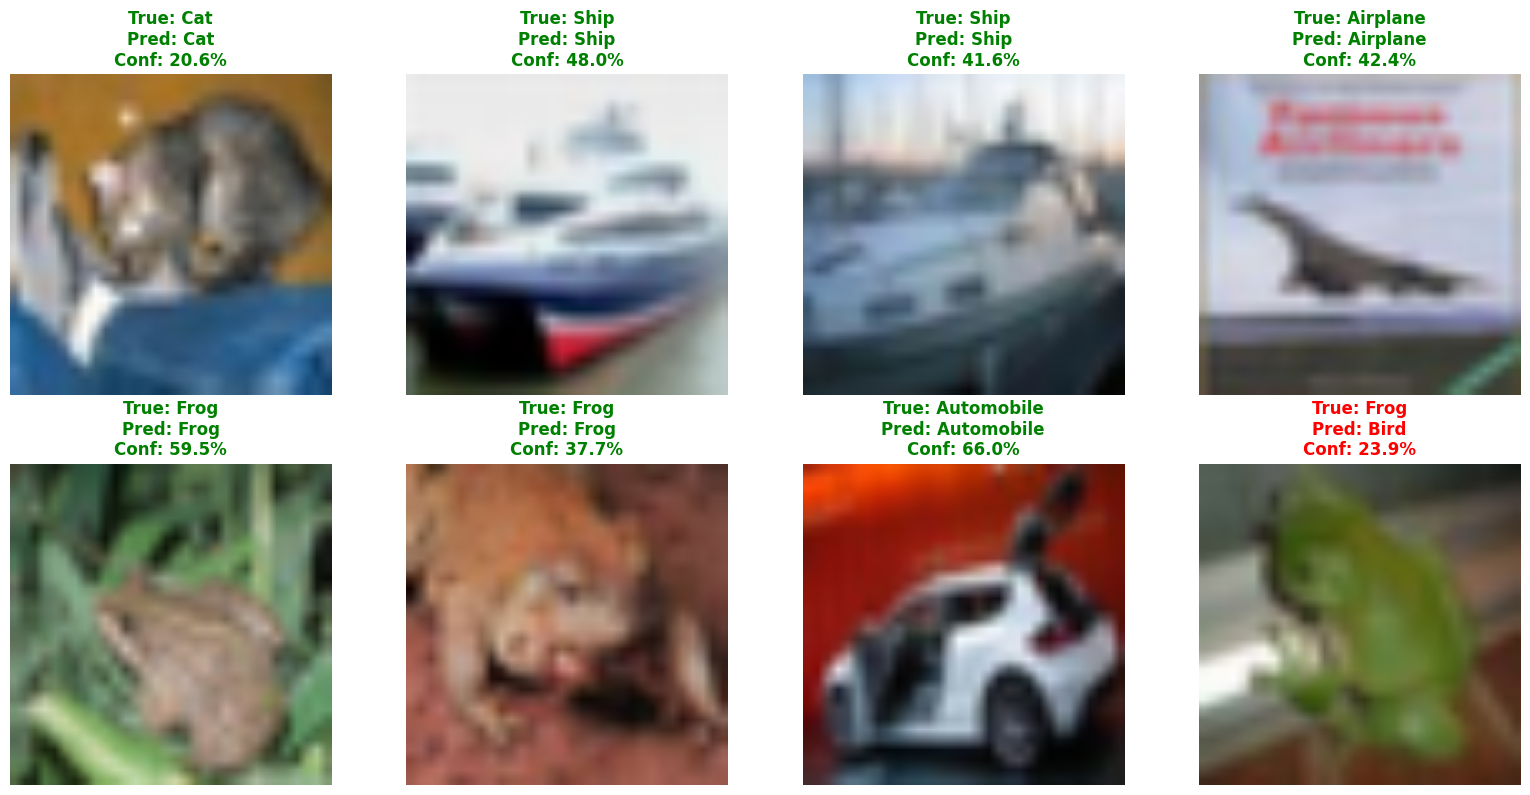


📊 Batch accuracy: 87.5% (7/8)


In [12]:
# CIFAR-10 class names
cifar10_classes = [
    'Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
    'Dog', 'Frog', 'Horse', 'Ship', 'Truck'
]

def predict_sample_images(model, val_loader, num_samples=8):
    """Predict và visualize sample images"""
    
    model.eval()
    
    # Get a batch of validation data
    data_iter = iter(val_loader)
    images, labels = next(data_iter)
    
    # Take first few samples
    images = images[:num_samples]
    labels = labels[:num_samples]
    
    # Move to device
    images = images.to(device)
    labels = labels.to(device)
    
    # Predict
    with torch.no_grad():
        with autocast():
            outputs = model(images)
            _, predicted = outputs.max(1)
            probabilities = torch.softmax(outputs, dim=1)
    
    # Convert back to CPU for visualization
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()
    probabilities = probabilities.cpu()
    
    # Visualize results
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for i in range(num_samples):
        # Denormalize image
        img = images[i].clone()
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        
        # Display image
        axes[i].imshow(img.permute(1, 2, 0))
        
        # Get prediction info
        true_class = cifar10_classes[labels[i]]
        pred_class = cifar10_classes[predicted[i]]
        confidence = probabilities[i][predicted[i]] * 100
        
        # Color code: green if correct, red if wrong
        color = 'green' if labels[i] == predicted[i] else 'red'
        
        axes[i].set_title(
            f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%',
            color=color, fontweight='bold'
        )
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate accuracy for this batch
    correct = (predicted == labels).sum().item()
    accuracy = correct / len(labels) * 100
    print(f"\n📊 Batch accuracy: {accuracy:.1f}% ({correct}/{len(labels)})")
    
    return images, labels, predicted, probabilities

# Run sample predictions
print("🖼️ Running sample predictions...")
sample_images, sample_labels, sample_preds, sample_probs = predict_sample_images(inference_model, val_loader)

## 11. Model Export và Optimization Tips

Xuất model và tips tối ưu hóa thêm

In [13]:
# Export model cho production\ndef export_optimized_model(model, save_path=\"swin_rtx3060_optimized\"):\n    \"\"\"Export model với các format khác nhau\"\"\"\n    \n    print(\"📦 Exporting optimized model...\")\n    \n    # 1. Save complete model\n    torch.save({\n        'model_state_dict': model.state_dict(),\n        'model_config': {\n            'num_classes': 10,\n            'model_size': 'tiny',\n            'input_size': 224\n        },\n        'optimization_settings': {\n            'batch_size': optimal_batch_size,\n            'mixed_precision': True,\n            'gradient_checkpointing': True\n        }\n    }, f\"{save_path}_complete.pth\")\n    print(f\"✅ Complete model saved: {save_path}_complete.pth\")\n    \n    # 2. Export to TorchScript untuk production\n    model.eval()\n    dummy_input = torch.randn(1, 3, 224, 224, device=device)\n    \n    try:\n        # TorchScript trace\n        with torch.no_grad():\n            traced_model = torch.jit.trace(model, dummy_input)\n        traced_model.save(f\"{save_path}_traced.pt\")\n        print(f\"✅ TorchScript model saved: {save_path}_traced.pt\")\n    except Exception as e:\n        print(f\"⚠️ TorchScript export failed: {e}\")\n    \n    # 3. Export ONNX (optional)\n    try:\n        torch.onnx.export(\n            model,\n            dummy_input,\n            f\"{save_path}.onnx\",\n            export_params=True,\n            opset_version=11,\n            do_constant_folding=True,\n            input_names=['input'],\n            output_names=['output'],\n            dynamic_axes={'input': {0: 'batch_size'},\n                         'output': {0: 'batch_size'}}\n        )\n        print(f\"✅ ONNX model saved: {save_path}.onnx\")\n    except Exception as e:\n        print(f\"⚠️ ONNX export failed: {e}\")\n\n# Export model\nexport_optimized_model(inference_model)\n\nprint(\"\\n\" + \"=\"*80)\nprint(\"🎯 SWIN TRANSFORMER RTX 3060 OPTIMIZATION SUMMARY\")\nprint(\"=\"*80)\nprint(\"🔧 MEMORY OPTIMIZATIONS APPLIED:\")\nprint(\"   ✅ Mixed Precision Training (FP16)\")\nprint(\"   ✅ Gradient Checkpointing\")\nprint(\"   ✅ Optimal Batch Size Detection\")\nprint(\"   ✅ Gradient Accumulation\")\nprint(\"   ✅ Memory Monitoring & Cleanup\")\nprint(\"   ✅ Efficient Data Loading\")\nprint()\nprint(\"📊 KEY SETTINGS FOR RTX 3060 6GB:\")\nprint(f\"   📦 Recommended batch size: {optimal_batch_size}\")\nprint(f\"   🔢 Gradient accumulation: 4 steps\")\nprint(f\"   📈 Effective batch size: {optimal_batch_size * 4}\")\nprint(f\"   🧠 Model: Swin Transformer Tiny (28M params)\")\nprint(f\"   🎯 Input resolution: 224x224\")\nprint()\nprint(\"💡 ADDITIONAL TIPS FOR RTX 3060:\")\nprint(\"   • Sử dụng Swin-Tiny thay vì Swin-Base cho 6GB VRAM\")\nprint(\"   • Bật gradient checkpointing để giảm memory\")\nprint(\"   • Dùng mixed precision (AMP) để training nhanh hơn\")\nprint(\"   • Monitor memory usage thường xuyên\")\nprint(\"   • Giảm num_workers nếu bị thiếu RAM hệ thống\")\nprint(\"   • Có thể resize ảnh xuống 192x192 nếu cần thêm memory\")\nprint(\"=\"*80)\n\nprint_memory_usage(\"Final state\")